In [ ]:
# enable IE to call matlplotlib
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai import *
from fastai.vision import *
from sklearn.model_selection import train_test_split
import requests
import pprint
import os
import json

In [ ]:
!mkdir -p ../data

!wget -P ../data https://storage.googleapis.com/np-training-public/datasets/kaggle-dogbreed/dog-breed-identification.zip 
!unzip ../data/dog-breed-identification.zip  -d ../data

In [ ]:
!unzip -q ../data/train.zip  -d ../data 
!unzip -q ../data/test.zip  -d ../data

In [3]:
PATH = '../data/'
sz = 224
arch = models.resnet34
bs = 32
!ls {PATH}

dog-breed-identification.zip  models		     test      train
labels.csv		      sample_submission.csv  test.zip  train.zip


In [4]:
files = os.listdir(f'{PATH}train')[:5]
files

['deb5ab49dab71dea5d3a076f00eb4820.jpg',
 '8f73fe936d2477bdbef77ebb0deaef78.jpg',
 '3cab06b69e8404ed0f90144ee4ef5271.jpg',
 '5a73316d885b4b6e4d9845100f762e4c.jpg',
 '5406eeabc4f6b981cc6f61cc7a335eae.jpg']

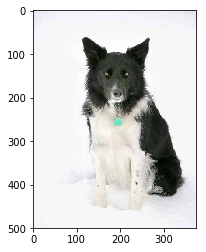

In [5]:
img = plt.imread(f'{PATH}train/{files[0]}')
plt.imshow(img);

In [6]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1


In [7]:
labels_df = pd.read_csv(label_csv)
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
label_csv

'../data/labels.csv'

In [9]:
tfms = get_transforms()


In [11]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

In [10]:
num_workers = 8
#size = 128

In [12]:
def get_data(size=64,bs=32,num_workers=8,valid_pct=0.2,tfms=tfms):
    data = ImageDataBunch.from_csv(path=PATH, folder='train', csv_labels='labels.csv', bs=bs, ds_tfms=tfms,  
                            suffix='.jpg', valid_pct=valid_pct, num_workers=num_workers, size=size).normalize(imagenet_stats)
    
    return  data

In [13]:
data = get_data(224)

In [14]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier',
  'appenzeller',
  'australian_terrier',
  'basenji',
  'basset',
  'beagle',
  'bedlington_terrier',
  'bernese_mountain_dog',
  'black-and-tan_coonhound',
  'blenheim_spaniel',
  'bloodhound',
  'bluetick',
  'border_collie',
  'border_terrier',
  'borzoi',
  'boston_bull',
  'bouvier_des_flandres',
  'boxer',
  'brabancon_griffon',
  'briard',
  'brittany_spaniel',
  'bull_mastiff',
  'cairn',
  'cardigan',
  'chesapeake_bay_retriever',
  'chihuahua',
  'chow',
  'clumber',
  'cocker_spaniel',
  'collie',
  'curly-coated_retriever',
  'dandie_dinmont',
  'dhole',
  'dingo',
  'doberman',
  'english_foxhound',
  'english_setter',
  'english_springer',
  'entlebucher',
  'eskimo_dog',
  'flat-coated_retriever',
  'french_bulldog',
  'german_shepherd',
  'german_short-haired_pointer',
  'giant_schnauzer',
  'golden_retriever',
  'gordon_setter',
  'great_dane',
  'great_pyren

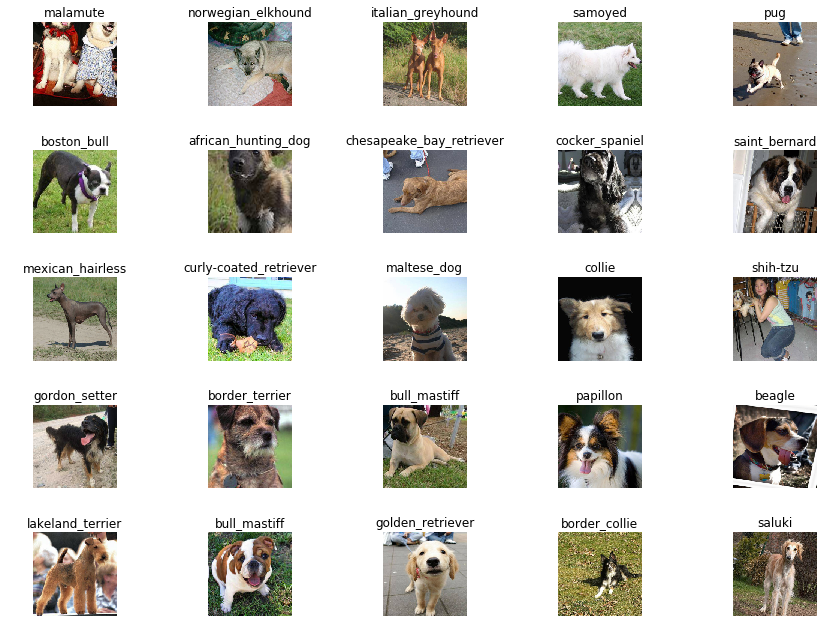

In [15]:
data.show_batch(rows=5, figsize=(12, 9))


In [16]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy],pretrained=True)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


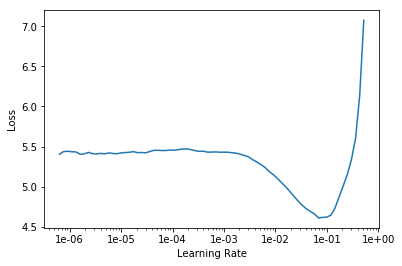

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
lr = 1e-2


In [19]:
learn.fit_one_cycle(6 , lr)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.612262,1.555747,0.436399,0.563601,00:27
1,1.985254,1.513544,0.414873,0.585127,00:27
2,1.510350,1.243097,0.350783,0.649217,00:28
3,1.182866,0.858267,0.265656,0.734344,00:28
4,0.835509,0.703240,0.212818,0.787182,00:27
5,0.677041,0.661572,0.203033,0.796967,00:27


In [20]:
learn.save(f'stage-1')


In [21]:
data = get_data(300)

In [22]:
learn.data = data


In [23]:
learn.fit_one_cycle(6 , lr)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.827351,0.629893,0.199609,0.800391,00:39
1,1.339496,1.005657,0.298924,0.701076,00:38
2,1.213974,0.991525,0.310176,0.689824,00:38
3,0.919125,0.678549,0.209393,0.790607,00:38
4,0.694051,0.537133,0.167319,0.832681,00:37
5,0.532392,0.502265,0.162427,0.837573,00:37


In [24]:
learn.save(f'stage-2')


In [25]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


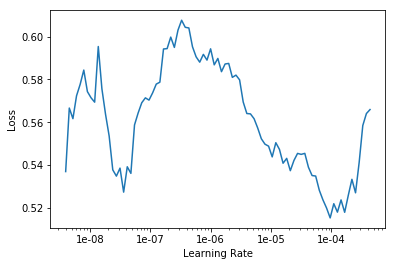

In [26]:
learn.lr_find(start_lr=1e-09, end_lr=1e-3)
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(5, max_lr=slice(1e-8,1e-4))

learn.save('stage-3')

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.517331,0.498074,0.160470,0.839530,00:47
1,0.534900,0.490941,0.155088,0.844912,00:47
2,0.485809,0.492703,0.151174,0.848826,00:47
3,0.500021,0.490129,0.150685,0.849315,00:47
4,0.516582,0.493101,0.149217,0.850783,00:47


In [28]:
learn.freeze()

In [29]:
interp = ClassificationInterpretation.from_learner(learn)


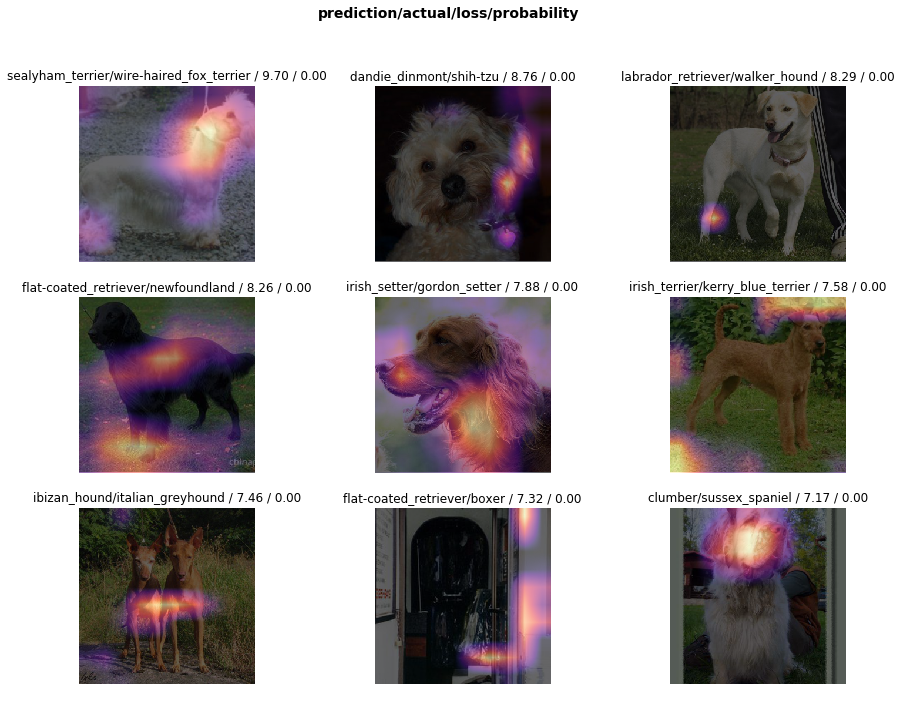

In [30]:
interp.plot_top_losses(9, figsize=(15,11))


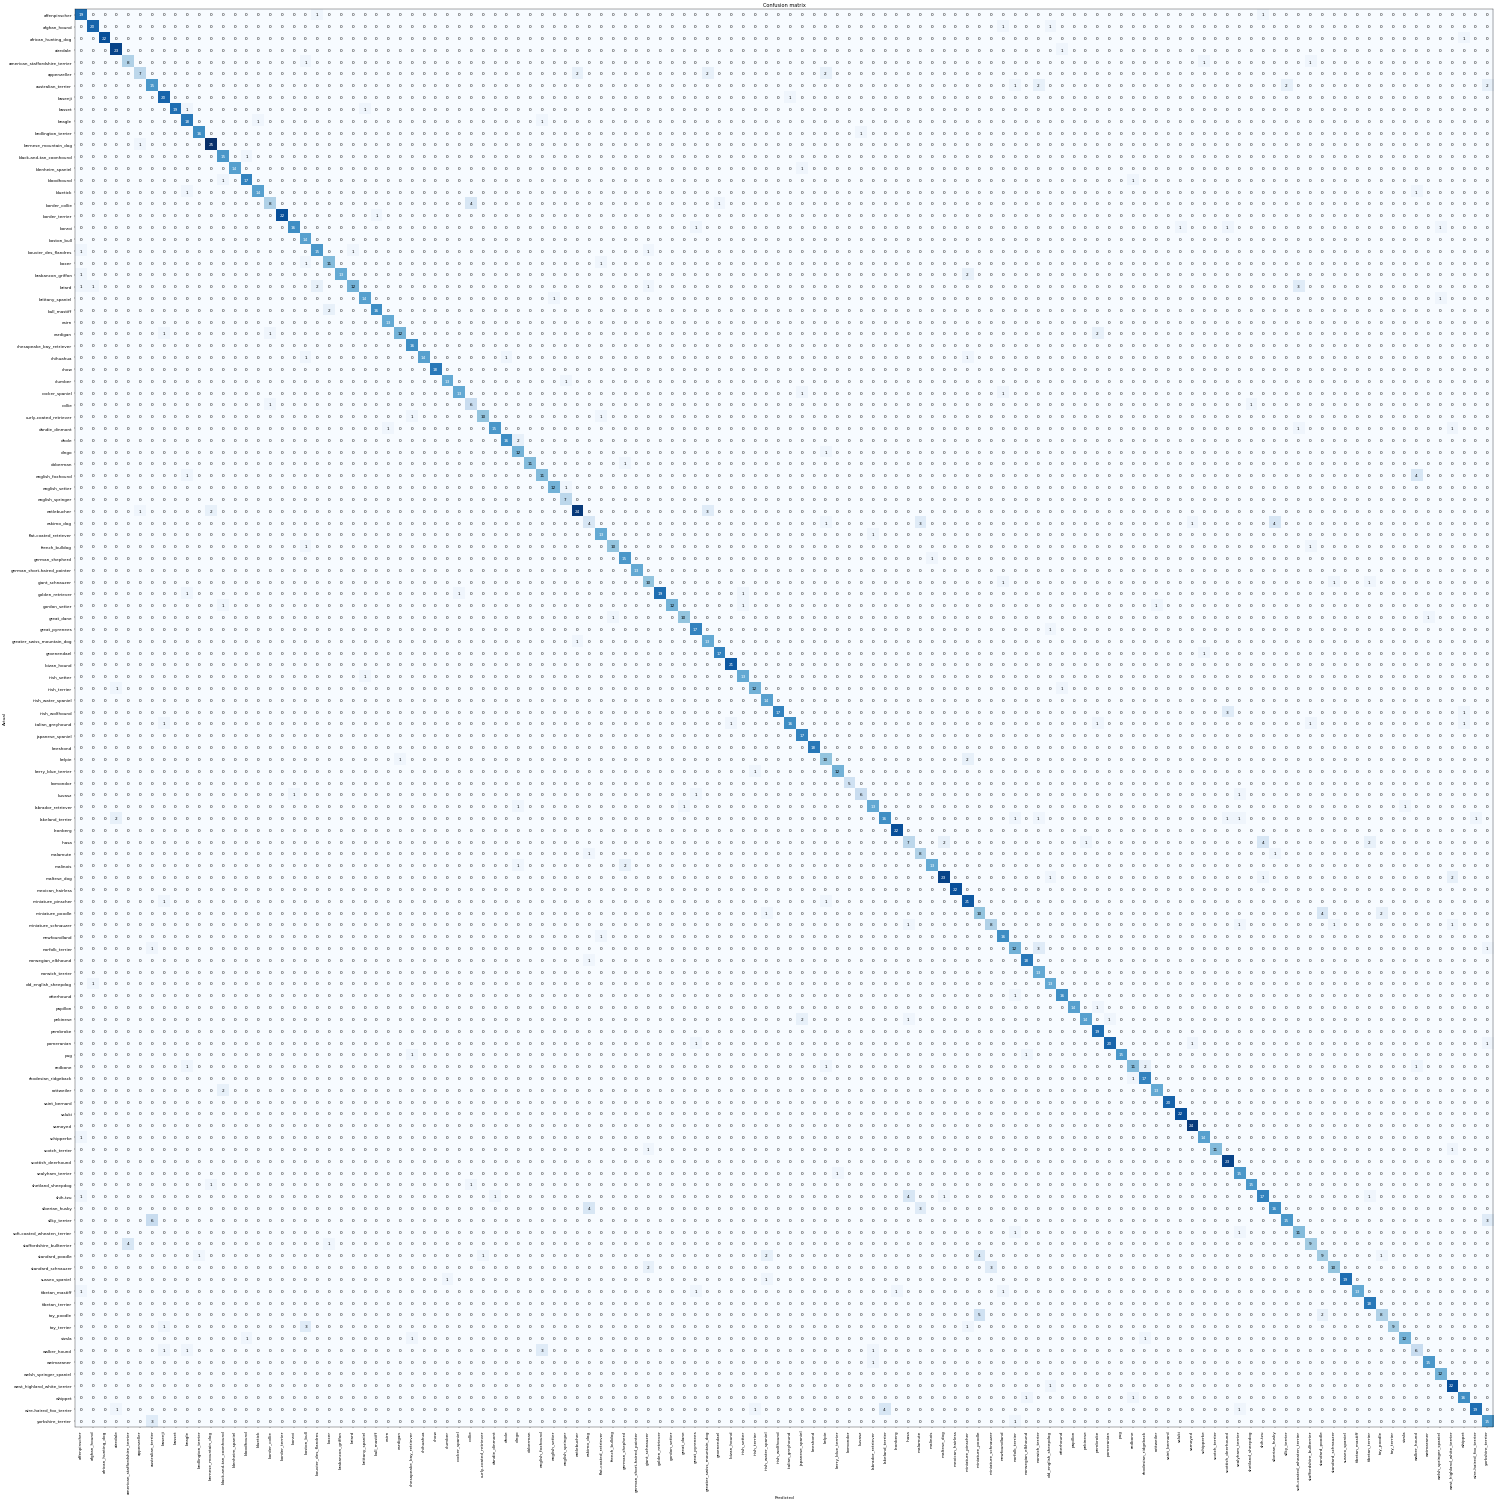

In [31]:
interp.plot_confusion_matrix(figsize=(50,50), dpi=30)


In [32]:
interp.most_confused(min_val=2)


[('silky_terrier', 'australian_terrier', 6),
 ('toy_poodle', 'miniature_poodle', 5),
 ('border_collie', 'collie', 4),
 ('english_foxhound', 'walker_hound', 4),
 ('eskimo_dog', 'siberian_husky', 4),
 ('lhasa', 'shih-tzu', 4),
 ('miniature_poodle', 'standard_poodle', 4),
 ('shih-tzu', 'lhasa', 4),
 ('siberian_husky', 'eskimo_dog', 4),
 ('staffordshire_bullterrier', 'american_staffordshire_terrier', 4),
 ('standard_poodle', 'miniature_poodle', 4),
 ('wire-haired_fox_terrier', 'lakeland_terrier', 4),
 ('briard', 'soft-coated_wheaten_terrier', 3),
 ('entlebucher', 'greater_swiss_mountain_dog', 3),
 ('eskimo_dog', 'malamute', 3),
 ('irish_wolfhound', 'scottish_deerhound', 3),
 ('norfolk_terrier', 'norwich_terrier', 3),
 ('siberian_husky', 'malamute', 3),
 ('silky_terrier', 'yorkshire_terrier', 3),
 ('standard_schnauzer', 'miniature_schnauzer', 3),
 ('toy_terrier', 'boston_bull', 3),
 ('walker_hound', 'english_foxhound', 3),
 ('yorkshire_terrier', 'australian_terrier', 3),
 ('appenzeller', 'e

In [33]:
def fetch_image(url):
    response = requests.get(url)
    img = open_image(BytesIO(response.content))
    return img

def predict(url):
    img = fetch_image(url)
    
    pred_class,pred_idx,outputs = learn.predict(img)
    res =  zip (learn.data.classes, outputs.tolist())
    predictions = sorted(res, key=lambda x:x[1], reverse=True)
    top_predictions = predictions[0:5]
    
    pprint.pprint( top_predictions)
    
    return img.resize(224)

In [34]:
img_chihuahua = "https://upload.wikimedia.org/wikipedia/commons/4/4c/Chihuahua1_bvdb.jpg"


[('chihuahua', 0.6544671058654785),
 ('dhole', 0.1523384004831314),
 ('pomeranian', 0.06658486276865005),
 ('papillon', 0.022562474012374878),
 ('australian_terrier', 0.017795758321881294)]


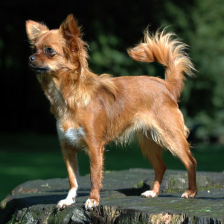

In [35]:
predict(img_chihuahua)

In [36]:
img_poodle = "https://upload.wikimedia.org/wikipedia/commons/f/f8/Full_attention_%288067543690%29.jpg"

[('standard_poodle', 0.7812302708625793),
 ('miniature_poodle', 0.21487008035182953),
 ('toy_poodle', 0.0021367117296904325),
 ('irish_water_spaniel', 0.0016937426989898086),
 ('curly-coated_retriever', 4.5204735215520486e-05)]


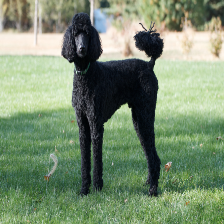

In [37]:
predict(img_poodle)

# Export

In [38]:
shutil.rmtree("../models",ignore_errors=True)
os.makedirs("../models")

In [39]:
final_model_directory = os.getcwd()+ "/../models"
final_model_name='model.pkl'

In [40]:
learn.export(final_model_directory+f"/{final_model_name}")


In [41]:
learn.data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [42]:
with open('../models/classes.txt', 'w') as f:
    json.dump(learn.data.classes,f)

# Load

In [43]:
learn3= load_learner(final_model_directory,final_model_name)


In [44]:
img = fetch_image(img_poodle)
learn3.predict(img)


(Category standard_poodle,
 tensor(105),
 tensor([1.0143e-07, 2.2853e-06, 2.7566e-08, 1.4472e-06, 3.3506e-10, 2.4003e-09,
         2.8772e-09, 2.4962e-07, 1.2424e-09, 2.7136e-09, 1.8560e-06, 6.1037e-09,
         7.4103e-07, 1.1153e-07, 1.2960e-08, 2.6253e-08, 5.2696e-10, 1.7493e-09,
         9.5929e-10, 6.5545e-09, 5.5765e-07, 6.9644e-10, 1.6040e-08, 4.3217e-08,
         3.1228e-08, 2.0798e-08, 1.1937e-09, 8.2593e-12, 3.6907e-09, 1.7807e-09,
         1.1724e-07, 1.2581e-08, 6.5575e-07, 3.9497e-10, 4.5205e-05, 5.6401e-08,
         7.4202e-10, 1.4492e-08, 2.9775e-09, 9.1280e-09, 1.4295e-06, 6.7490e-08,
         4.6860e-09, 6.2138e-10, 6.6524e-07, 2.5523e-09, 5.5627e-11, 3.0873e-08,
         1.3663e-06, 5.1355e-09, 1.7017e-06, 1.1013e-08, 2.2261e-09, 5.1422e-09,
         3.8637e-07, 1.3912e-09, 1.7832e-06, 3.9971e-07, 1.6937e-03, 4.7430e-10,
         6.2361e-08, 2.2944e-08, 9.3402e-09, 1.1594e-09, 3.5933e-06, 5.7759e-07,
         1.4932e-08, 7.4086e-09, 1.3828e-08, 6.1000e-10, 7.2856e-08,

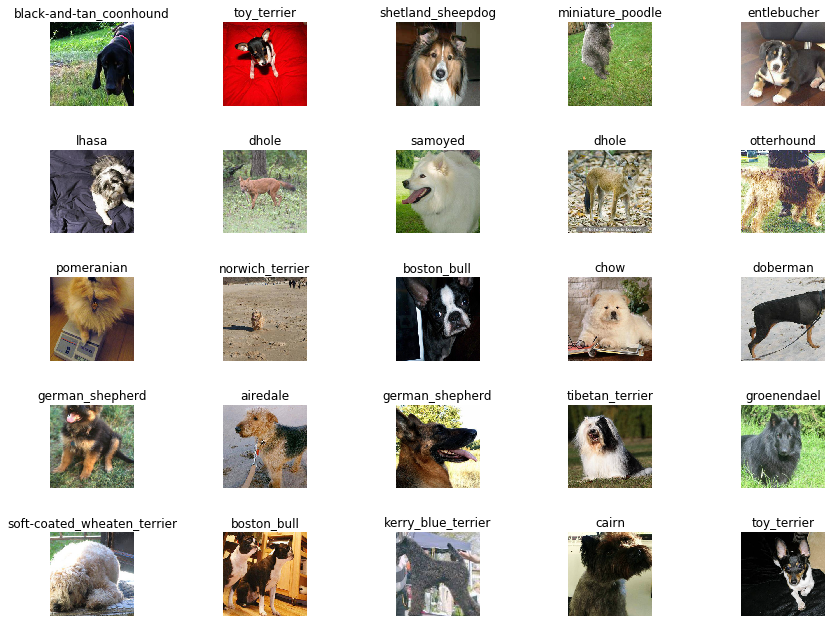

In [45]:
i2 =data.show_batch(rows=5, figsize=(12, 9))
